### Purpose of this notebook

- Generate a bunch of worlds and analyze their relational properties to help identify which are interesting, and to measure those properties in the population


In [2]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import blockworld_helpers as utils

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

### generate stimuli for norming/ prior study

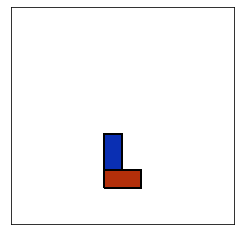

In [4]:
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

w = utils.World(block_dims = block_dims,
                block_colors = block_colors)

w.add_block(2,1,world_center,0)
w.snap_to_floor(1,2,world_center)
utils.draw_world(w)

In [38]:
w.get_block_dict()['blocks']

[{'x': 3, 'y': 0, 'height': 1, 'width': 2}]

### Enumerate upper bound of n-block towers

generate upper bound of stims by placing blocks in all x-positions, then adding a block to each of these in all positions

These define unique sequences of *block placements*, however many of the towers consist of the same blocks in the same place

In [32]:
# generate stims

max_blocks = 4

stims = {}

# single block in center of world
stims[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    stims[1].append(w.get_block_dict()['blocks'])


# add a block in all available locations to all existing towers of n-1 blocks
for n_blocks in range(2,max_blocks+1):
    stims[n_blocks] = []

    # add block in position
    for blocks in stims[n_blocks-1]:    
        for block in block_dims:
            for x in range(0, world_width-1):
                #repopulate world
                w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
                w.populate_from_block_list(blocks)

                #add new block
                w.snap_to_floor(block[0], # width
                            block[1], # height
                            x)
                stims[n_blocks].append(w.get_block_dict()['blocks'])


In [36]:
# how many of each? (not necessarily unique)
_ = [print(str(i) + ' block towers: ' + str(len(stims[i]))) for i in stims.keys()]

1 block towers: 2
2 block towers: 28
3 block towers: 392
4 block towers: 5488


### Equate towers of same blocks generated in different order

#### Sort blocks in tower

In [257]:
# sort the blocks within a tower to find unique towers
stims_sorted_blocks = [sorted(tower, key = lambda block: (block['x'],block['y'],block['height'],block['width'])) 
     for tower in stims[4]]

#### Align towers to left (ensures translational invariance)

In [259]:
# next task: translational invariance
# Equate towers that have the same configuration of blocks but show up in different places in the world

# Align all towers to left then check for equivalence

# find min x ordinate in all blocks

min_xs = [min([block['x'] for block in tower]) for tower in stims_sorted_blocks]

aligned_towers = [[{'x': block['x'] - min_x,
   'y': block['y'],
   'height': block['height'],
   'width': block['width']}
  for block in tower] for (tower, min_x) in zip(stims_sorted_blocks, min_xs)]

# subtract min x ordinate from all x-values


#### Align find unique towers

In [306]:
# convert dictionary representations of towers to (hashable) tuple and back

def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd

In [307]:
tower_tuples = [world_dicts_to_tuples(tower) for tower in aligned_towers]
print(str(len(tower_tuples)) + ' towers of 4 blocks')


unique_towers_tuples = set(tower_tuples)
print(str(len(unique_towers_tuples)) + ' unique towers of 4 blocks')


5488 towers of 4 blocks
1116 unique towers of 4 blocks


In [308]:
# all unique towers with 4 blocks (not contiguous)
unique_towers_dicts = [world_tuples_to_dicts(tower) for tower in unique_towers_tuples]

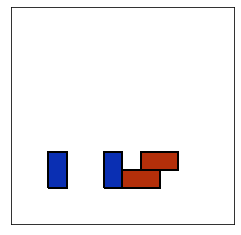

In [309]:
w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
w.populate_from_block_list(unique_towers_dicts[0])
utils.draw_world(w)

### Apply filters to towers

- connected
- at least 1 or 2 blocks off ground
- 2 horizontal, 2 vertical
- height
- max width




#### Filter non-connected towers

In [310]:
# Filter non-connected towers

# connectivity: 1 for just orthogonal, 2, for diagonal as well
connected_towers = [tower for tower in unique_towers_dicts\
                        if utils.worldify(tower).fully_connected(connectivity=1)]



In [311]:
print(str(len(connected_towers)) + ' unique connected towers of 4 blocks')

405 unique connected towers of 4 blocks


#### Filter towers based on how many blocks are off ground level

In [319]:
# Filter towers based on how many blocks are off ground level

min_blocks_supported = 2

towers_with_n_blocks_supported = [tower for tower in connected_towers \
                                  if utils.worldify(tower).blocks_above_ground(min_blocks_supported)]

print(str(len(towers_with_n_blocks_supported)) + ' towers with ' + str(min_blocks_supported) + ' or more blocks above ground-level')

303 towers with 2 or more blocks above ground-level


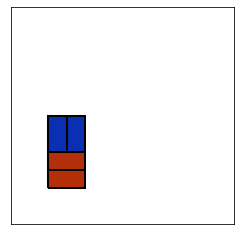

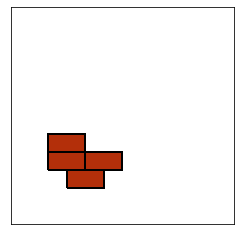

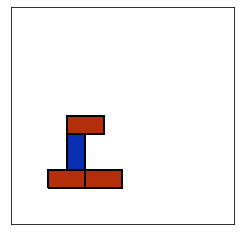

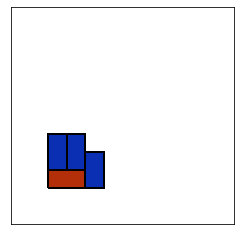

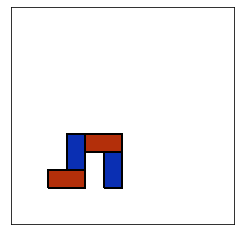

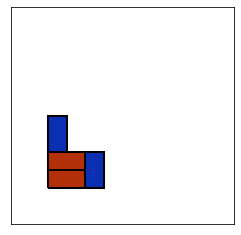

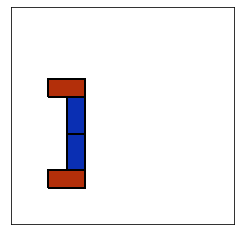

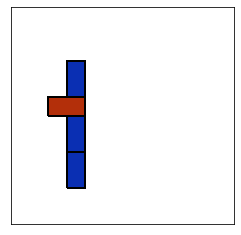

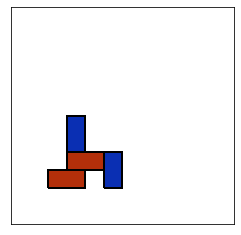

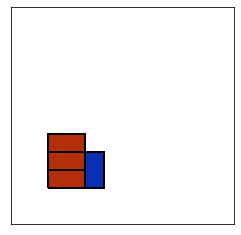

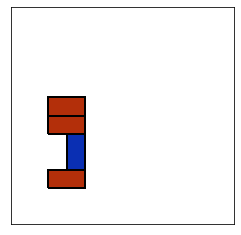

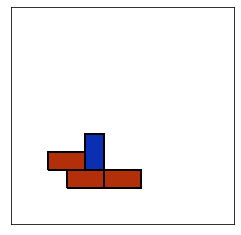

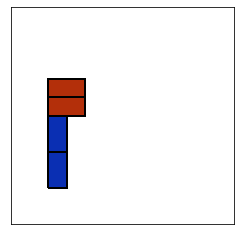

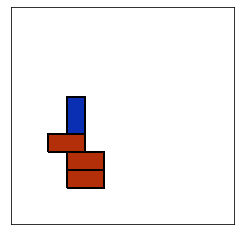

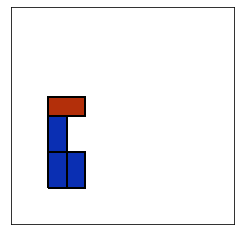

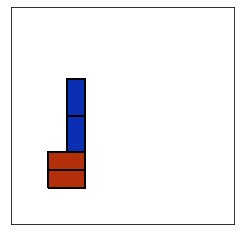

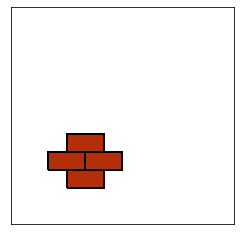

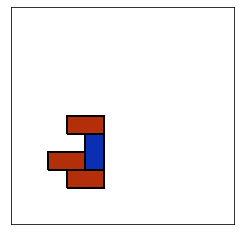

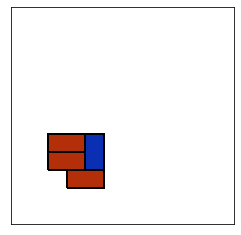

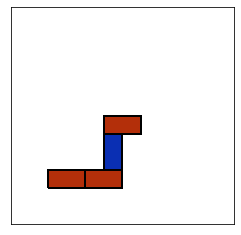

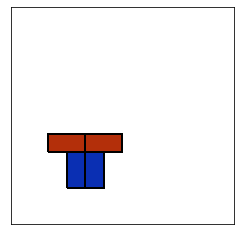

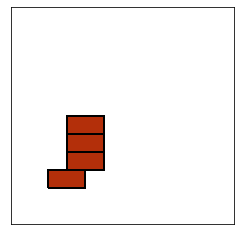

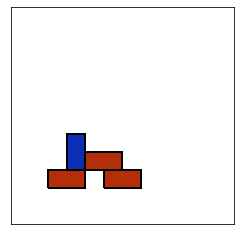

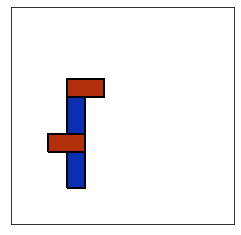

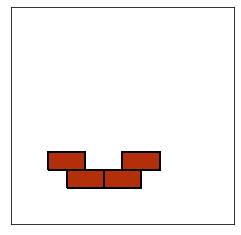

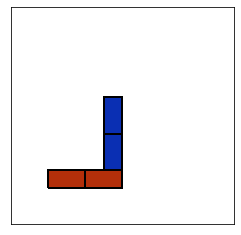

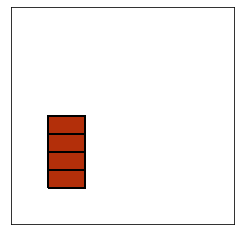

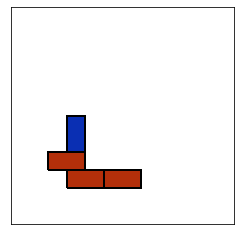

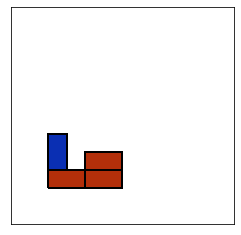

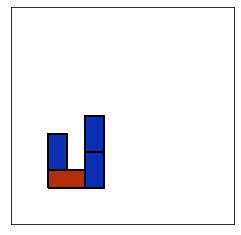

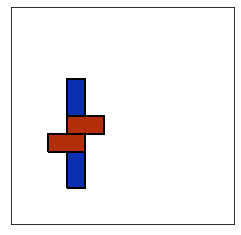

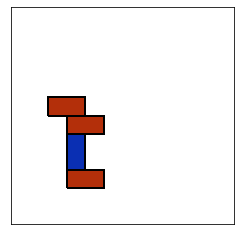

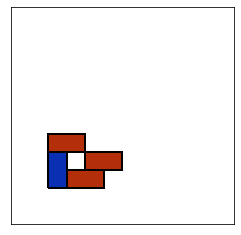

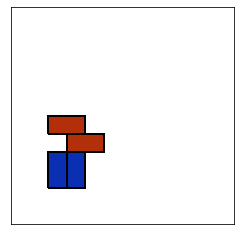

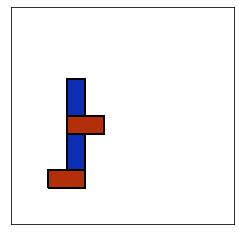

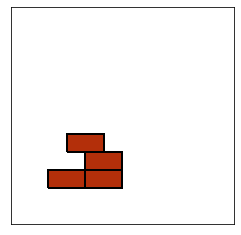

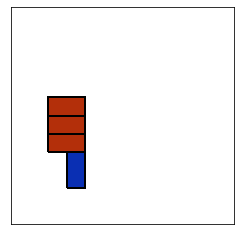

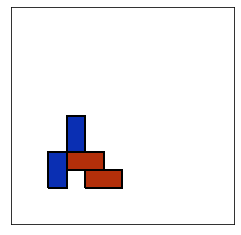

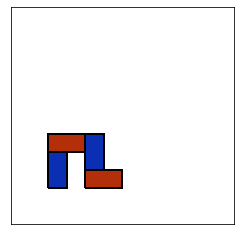

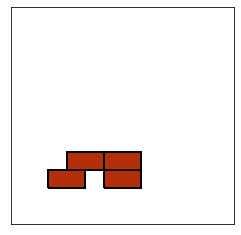

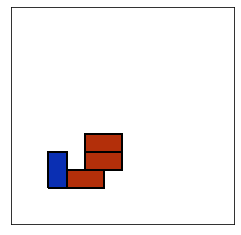

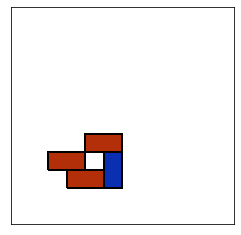

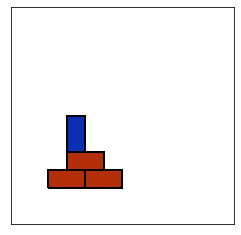

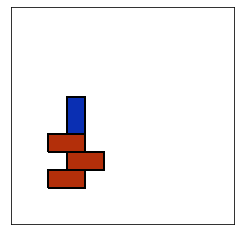

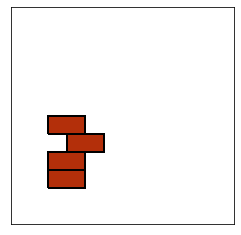

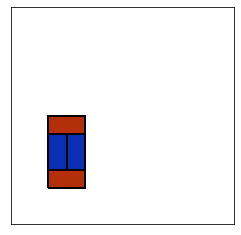

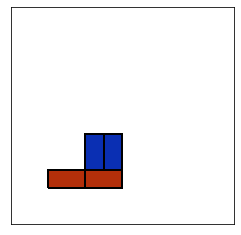

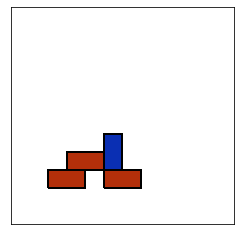

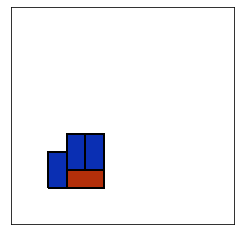

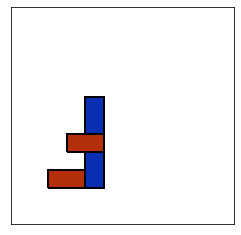

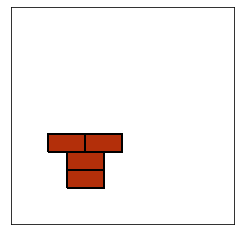

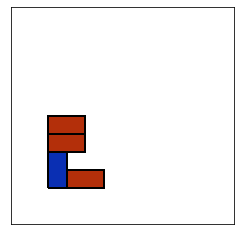

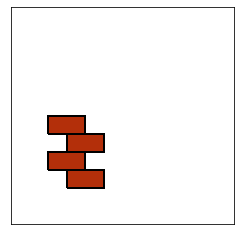

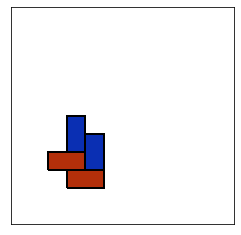

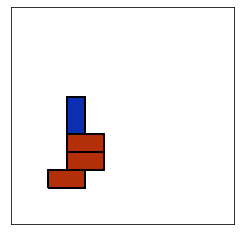

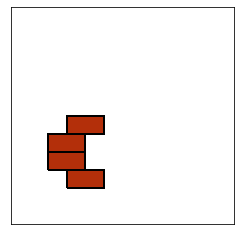

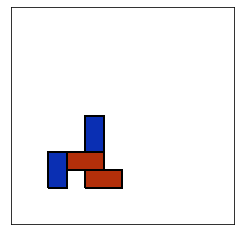

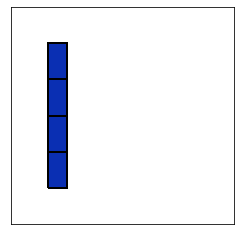

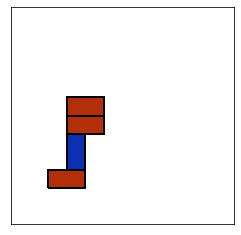

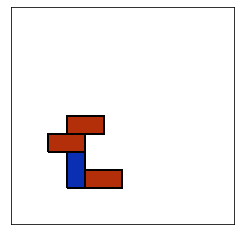

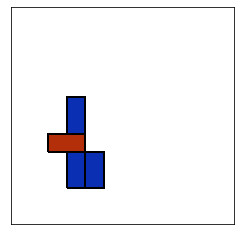

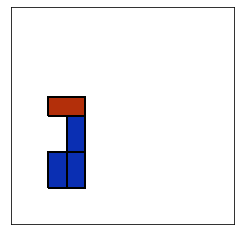

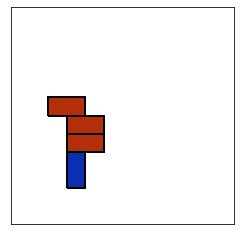

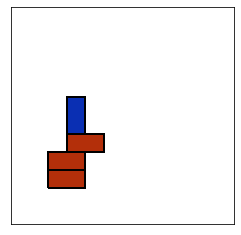

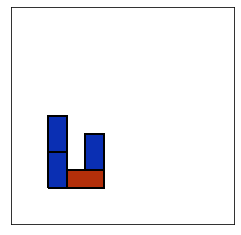

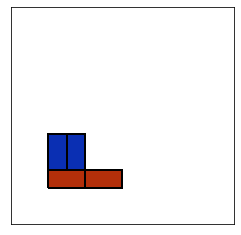

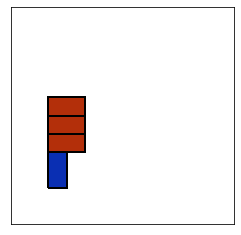

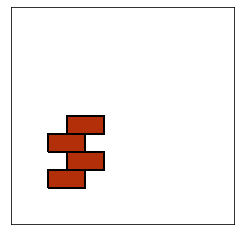

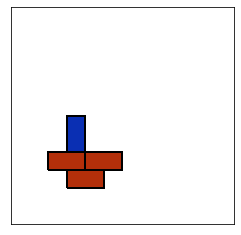

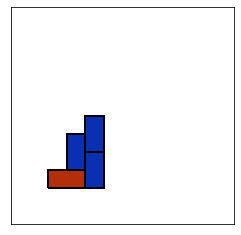

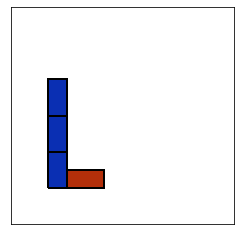

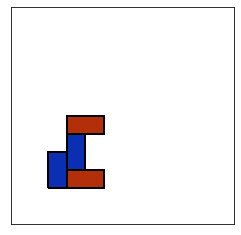

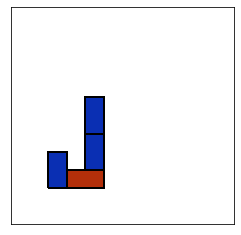

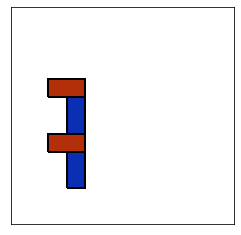

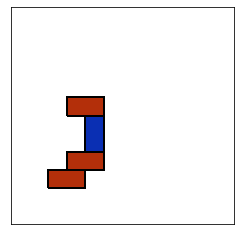

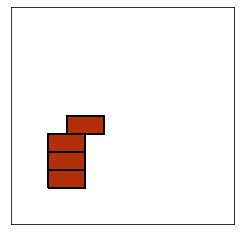

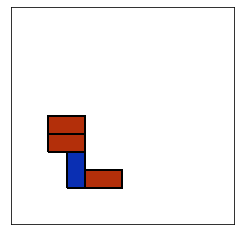

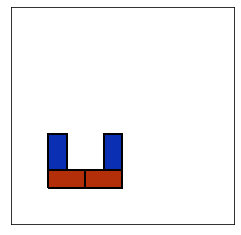

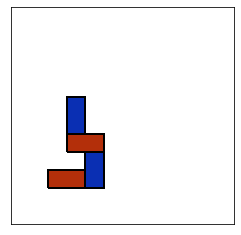

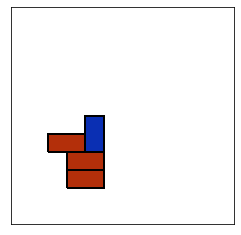

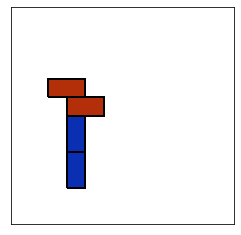

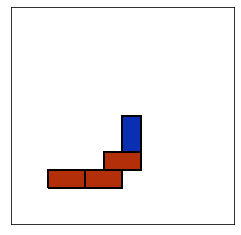

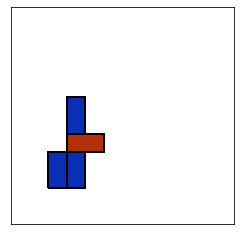

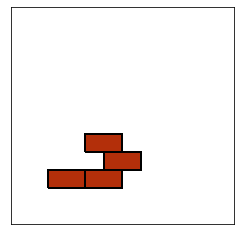

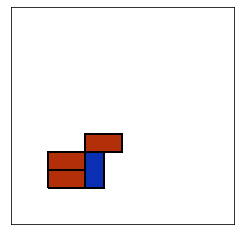

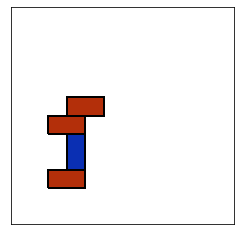

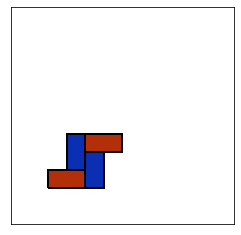

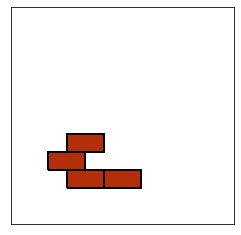

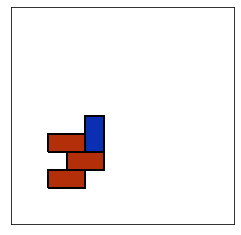

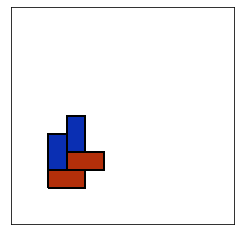

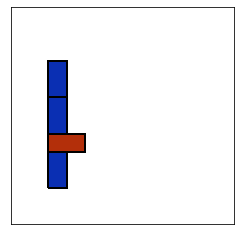

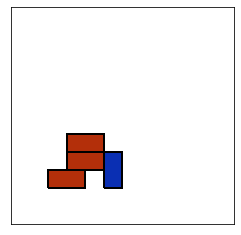

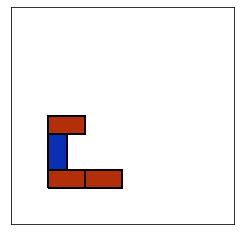

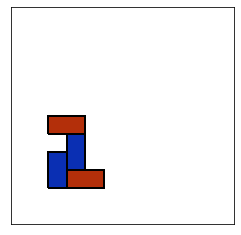

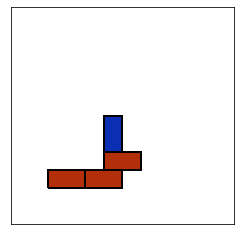

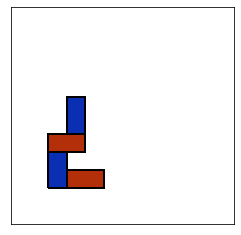

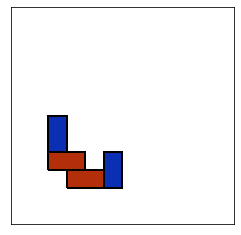

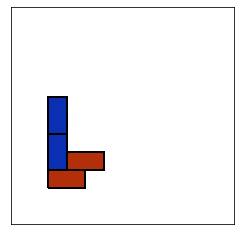

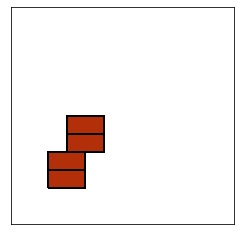

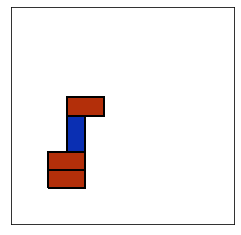

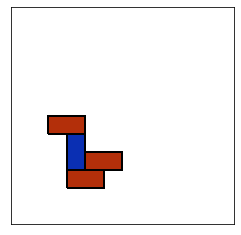

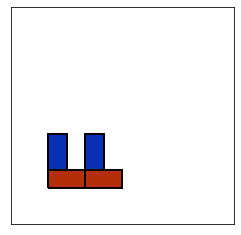

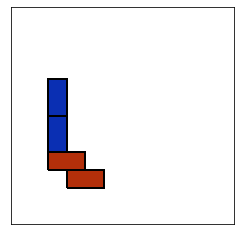

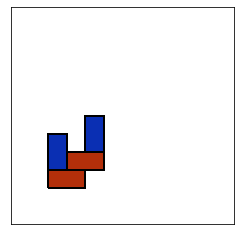

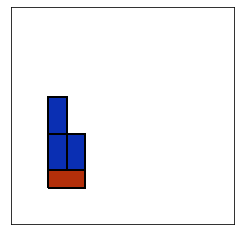

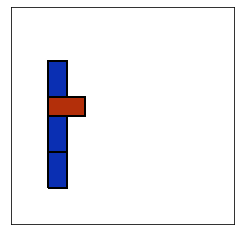

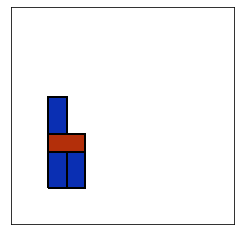

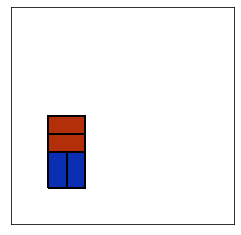

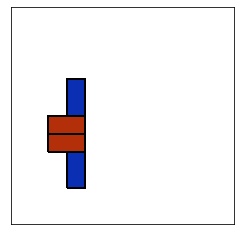

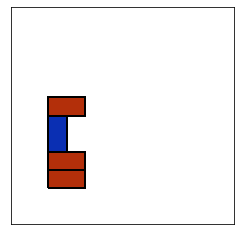

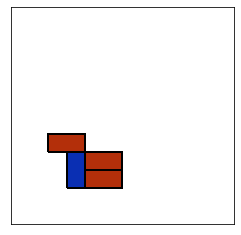

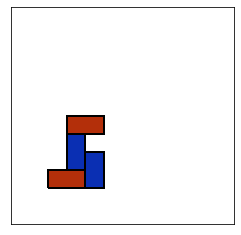

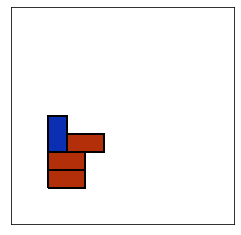

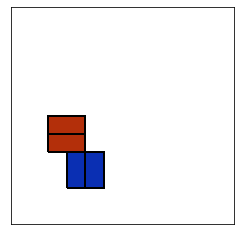

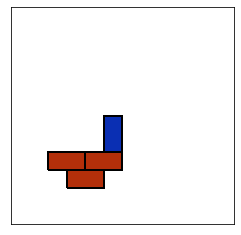

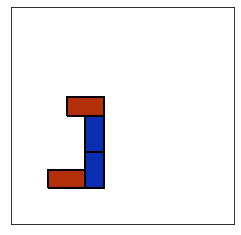

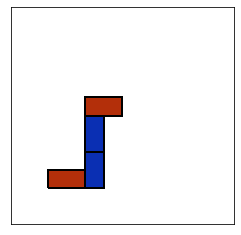

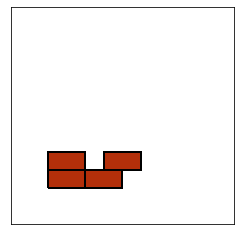

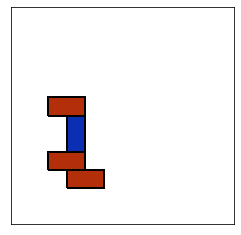

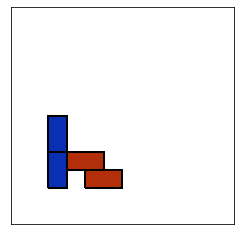

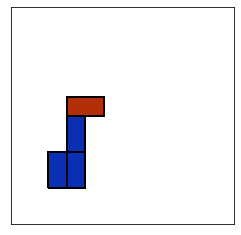

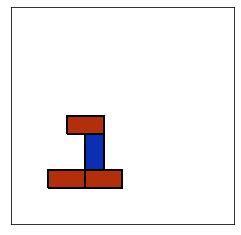

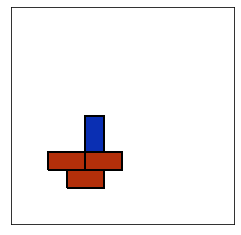

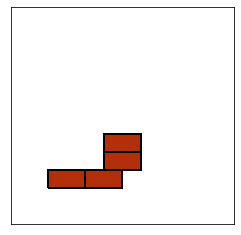

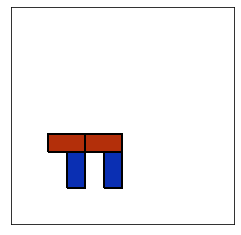

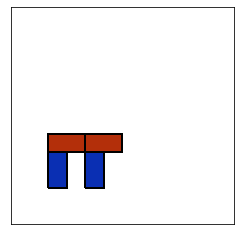

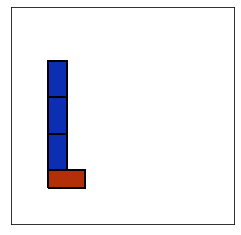

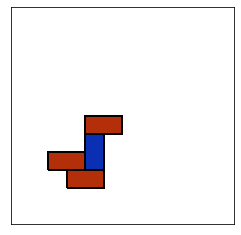

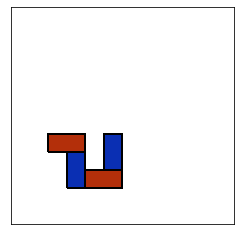

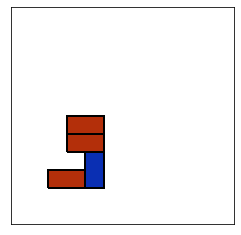

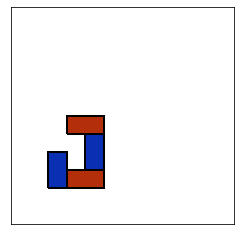

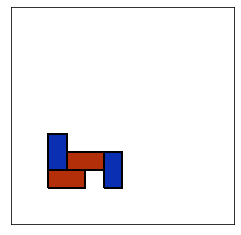

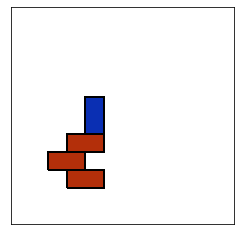

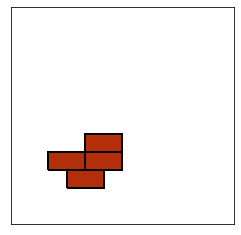

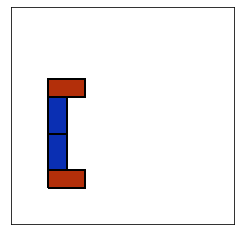

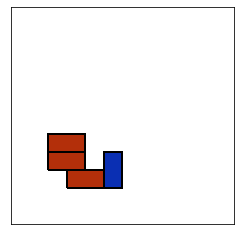

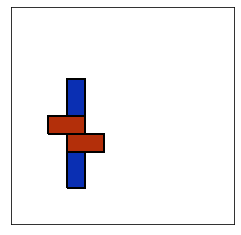

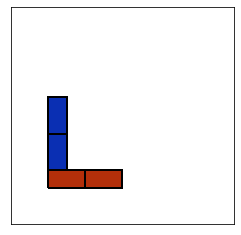

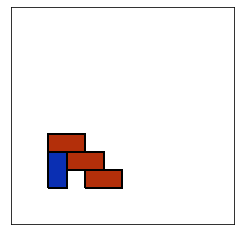

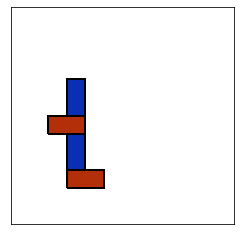

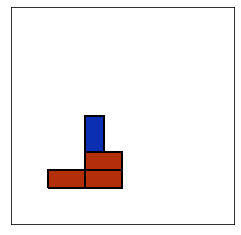

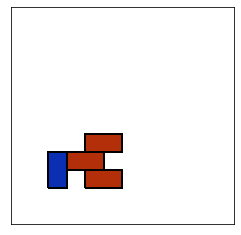

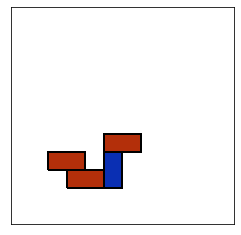

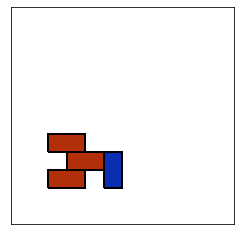

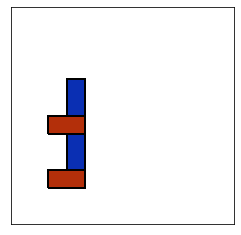

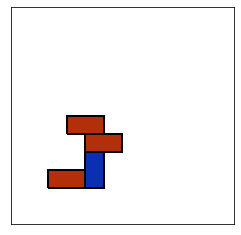

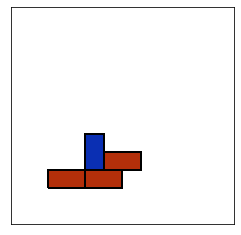

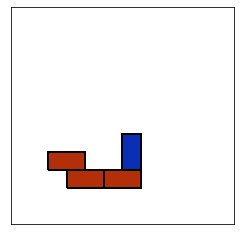

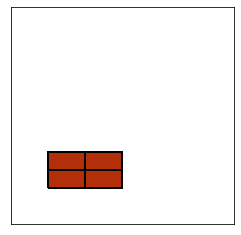

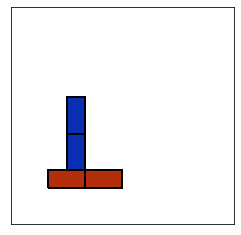

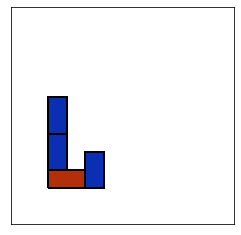

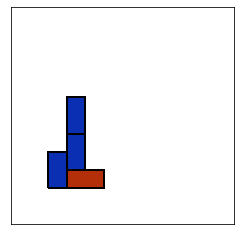

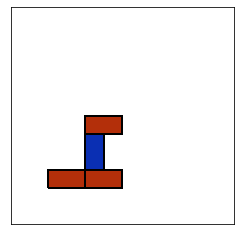

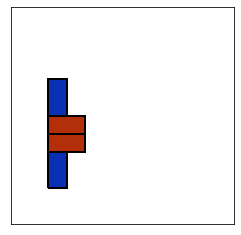

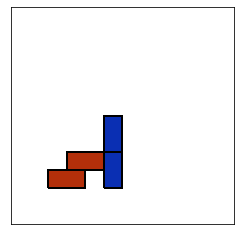

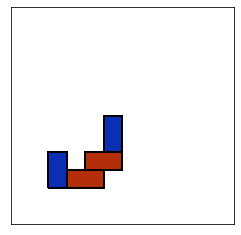

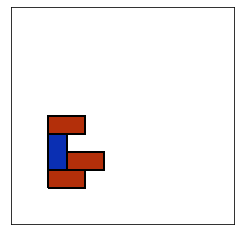

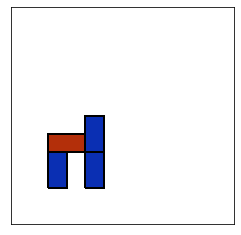

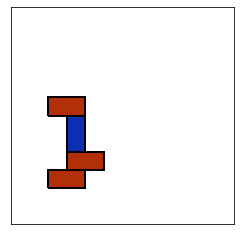

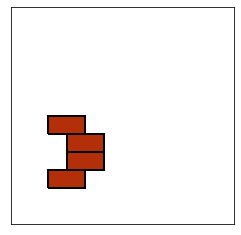

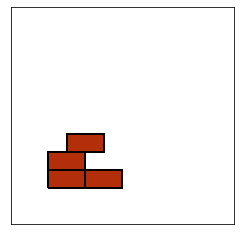

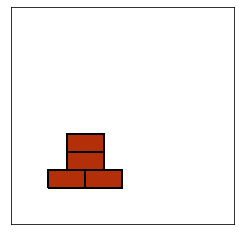

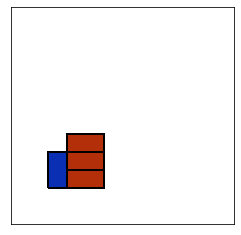

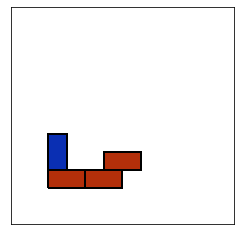

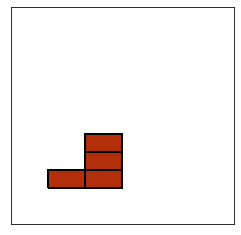

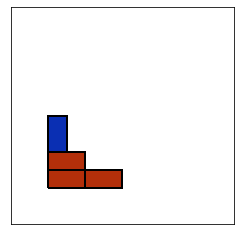

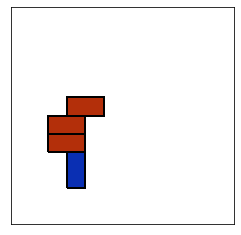

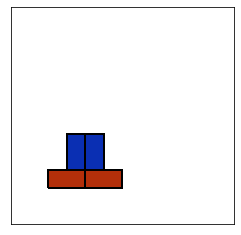

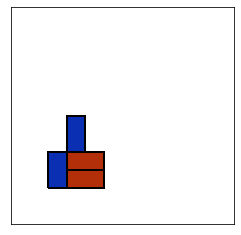

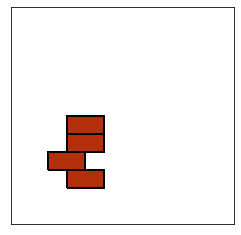

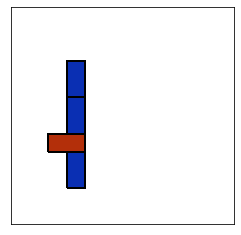

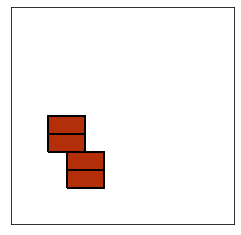

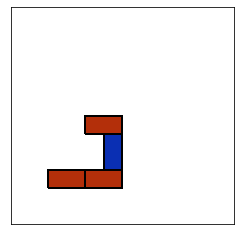

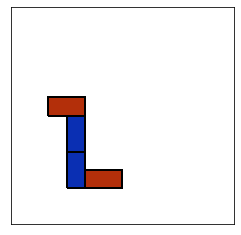

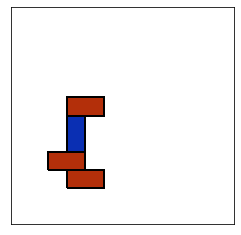

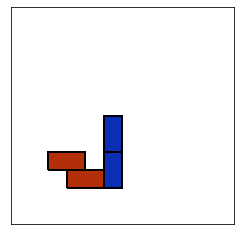

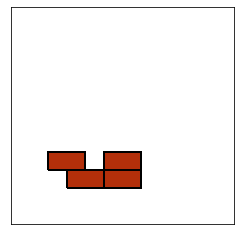

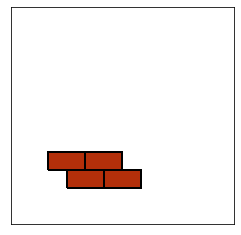

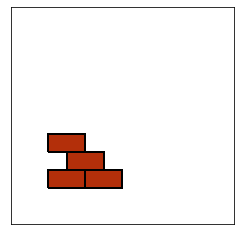

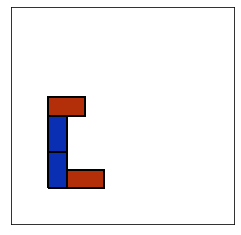

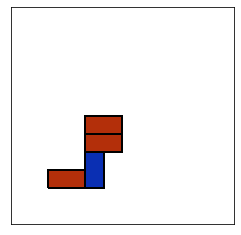

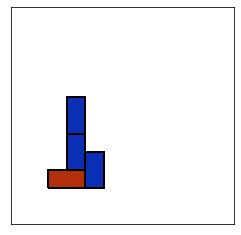

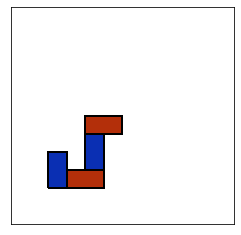

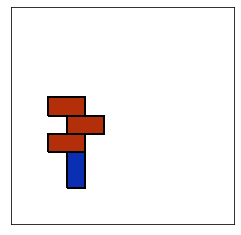

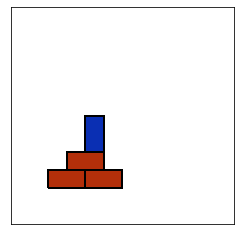

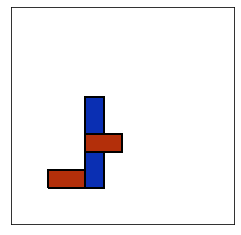

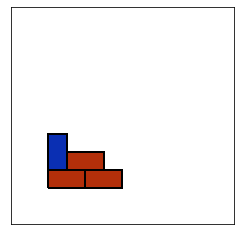

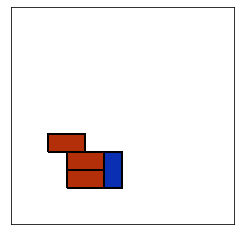

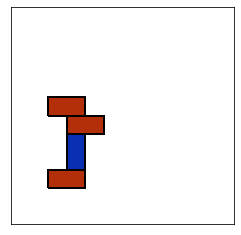

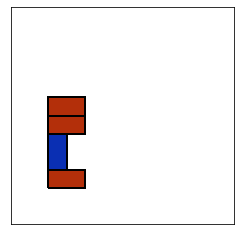

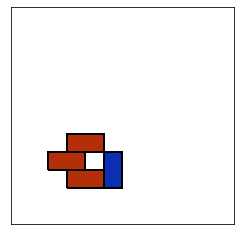

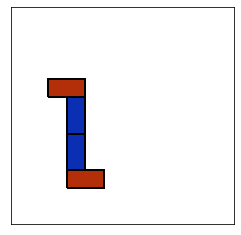

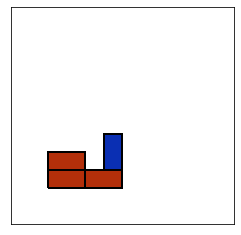

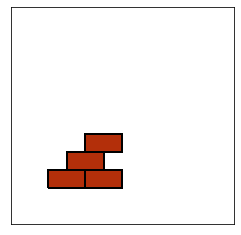

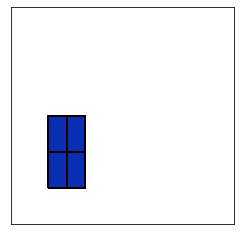

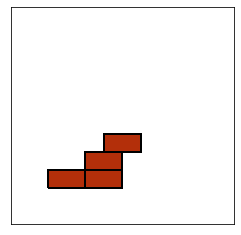

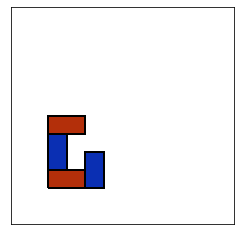

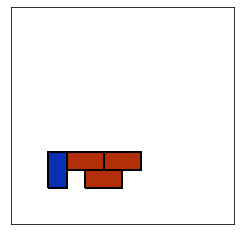

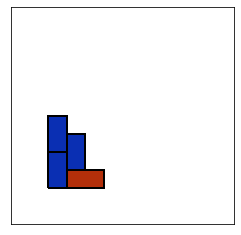

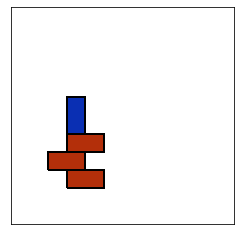

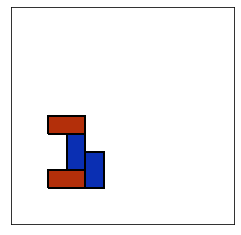

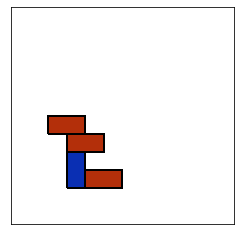

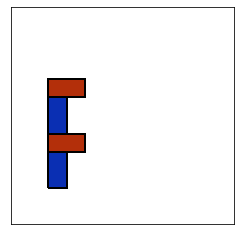

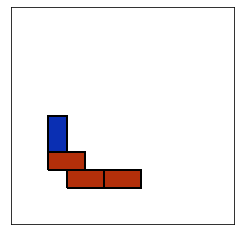

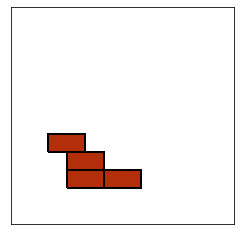

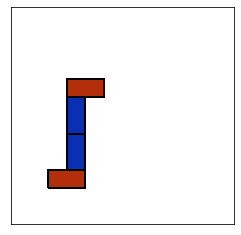

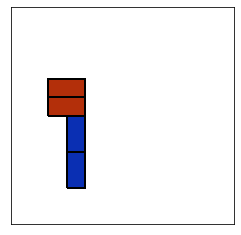

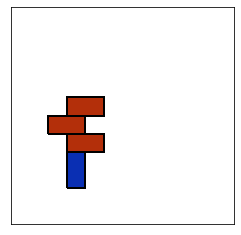

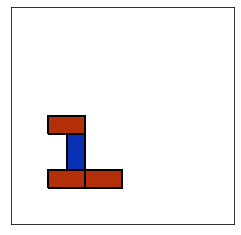

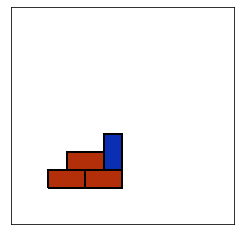

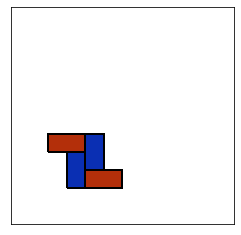

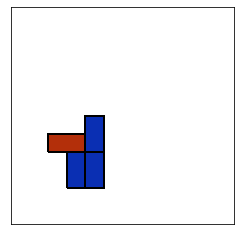

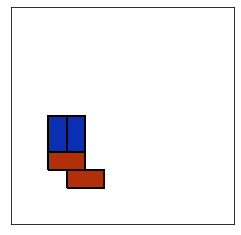

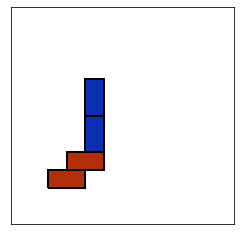

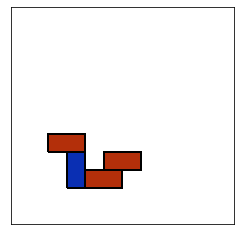

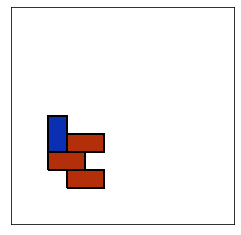

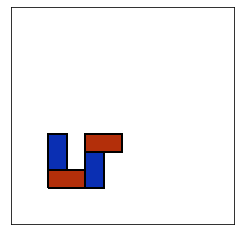

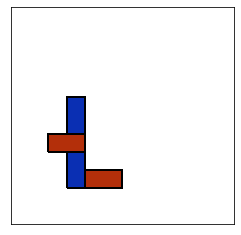

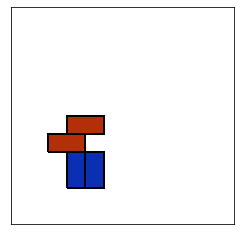

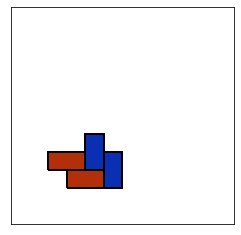

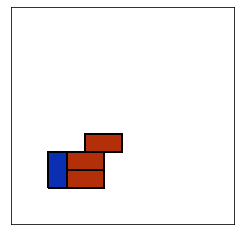

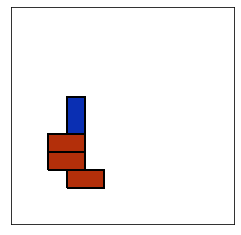

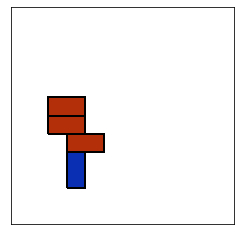

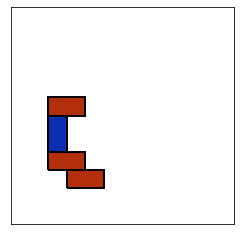

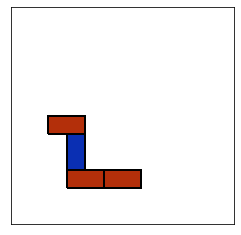

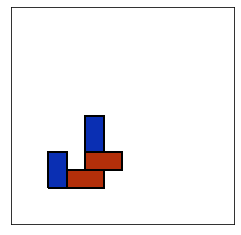

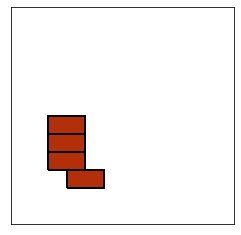

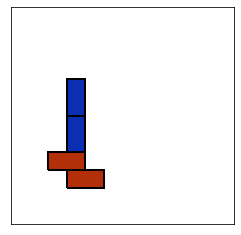

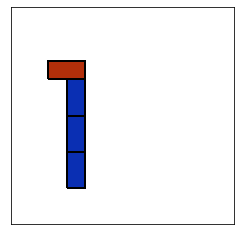

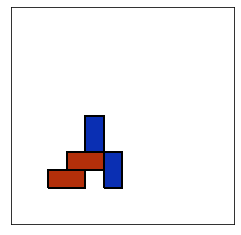

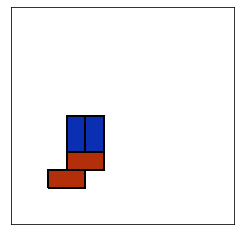

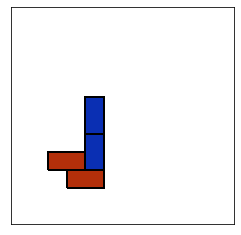

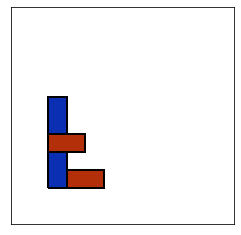

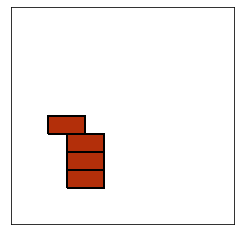

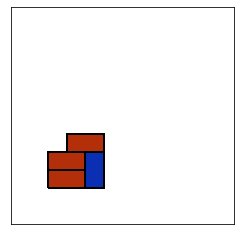

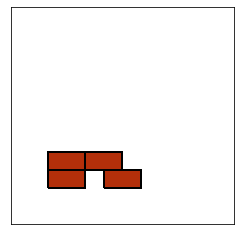

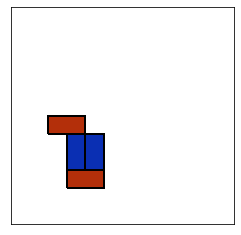

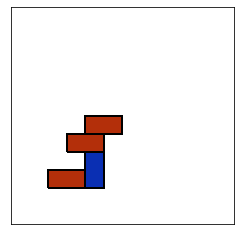

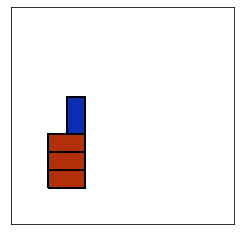

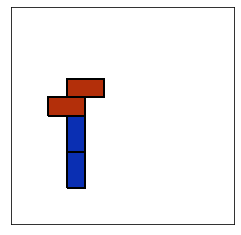

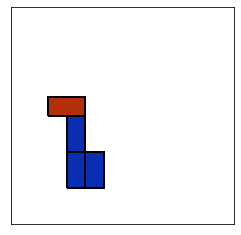

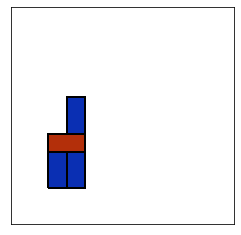

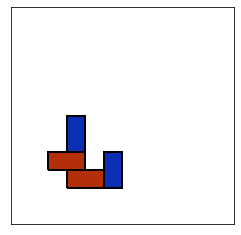

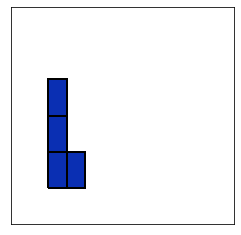

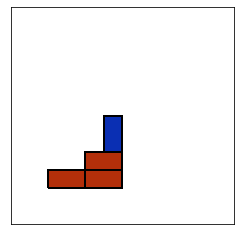

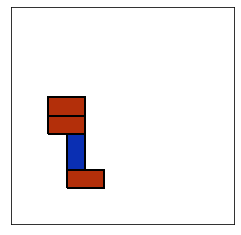

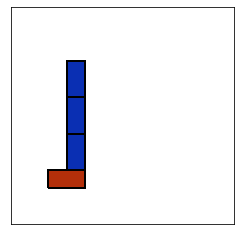

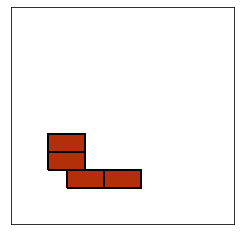

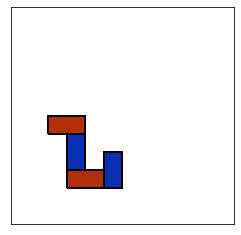

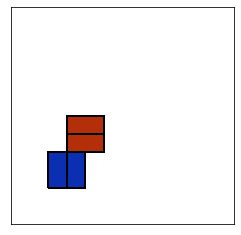

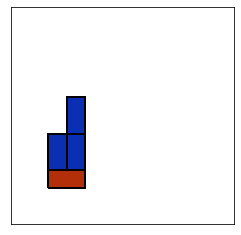

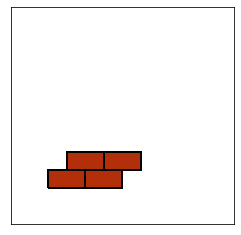

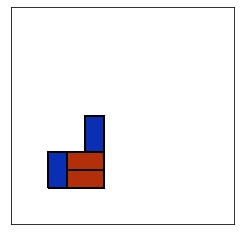

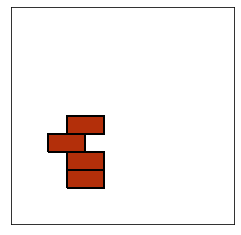

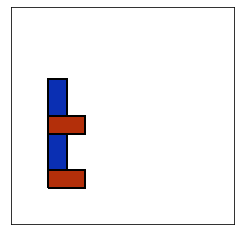

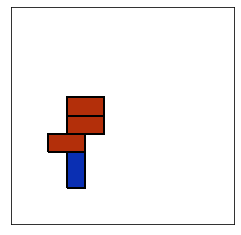

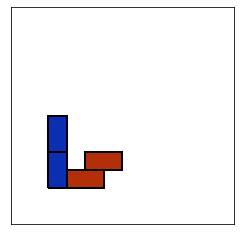

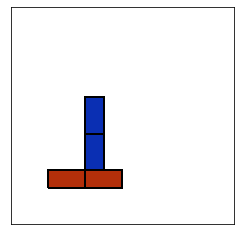

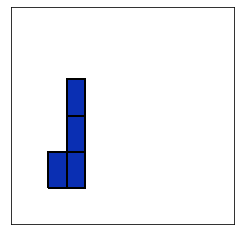

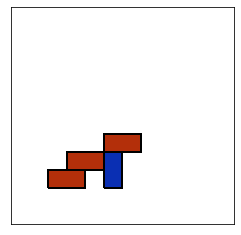

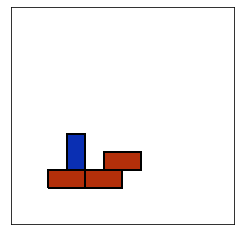

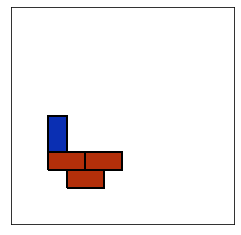

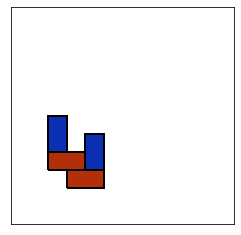

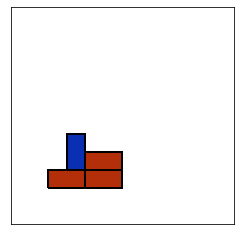

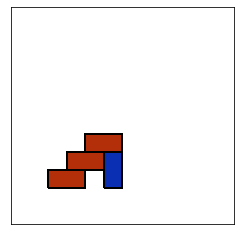

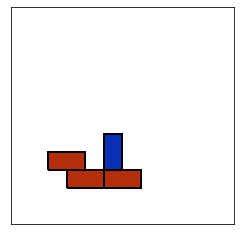

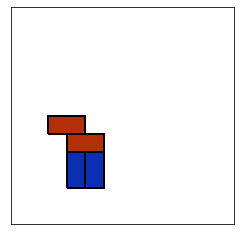

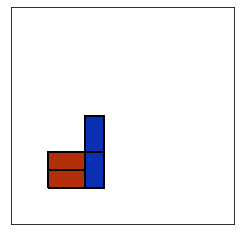

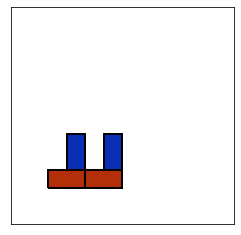

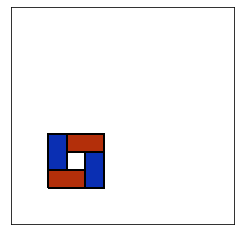

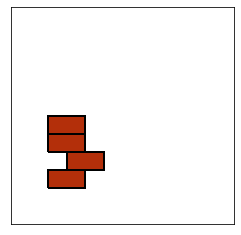

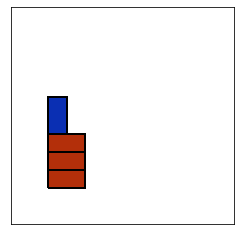

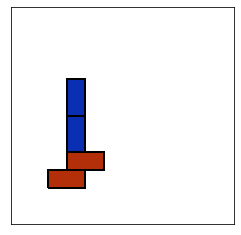

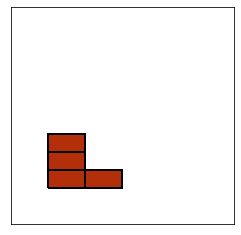

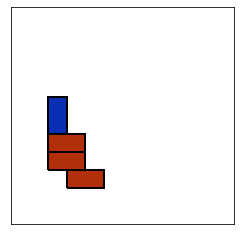

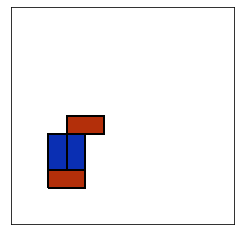

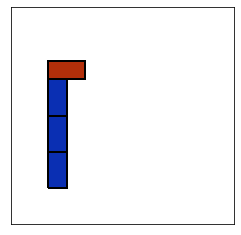

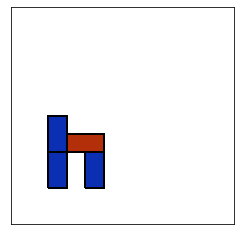

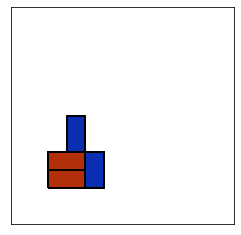

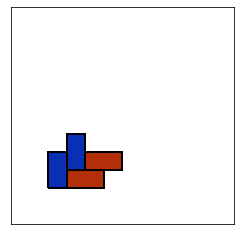

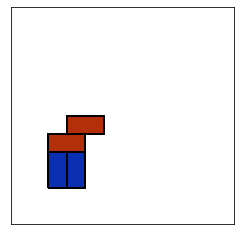

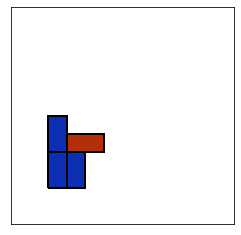

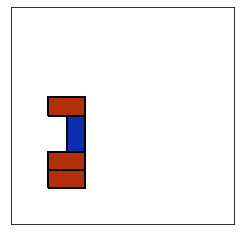

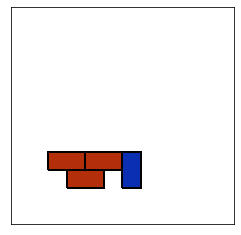

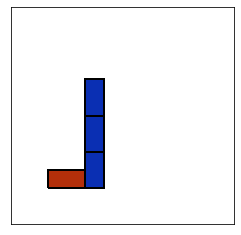

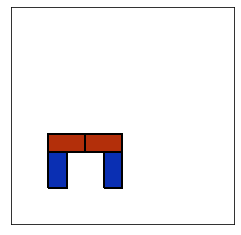

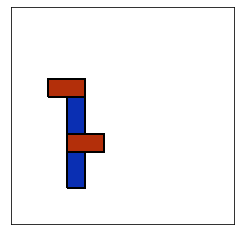

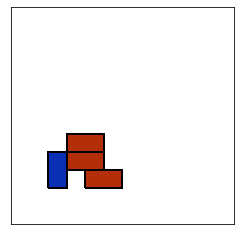

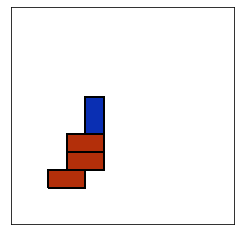

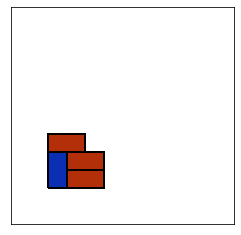

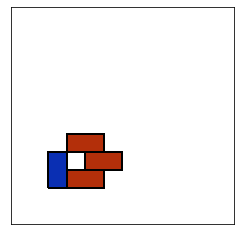

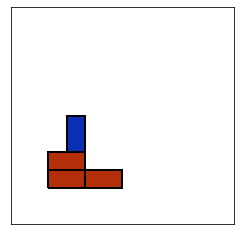

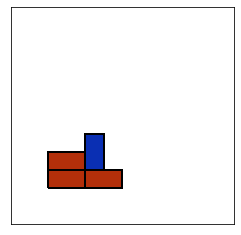

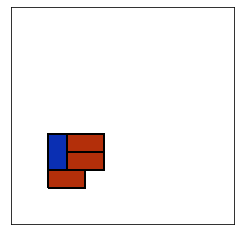

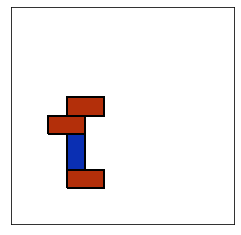

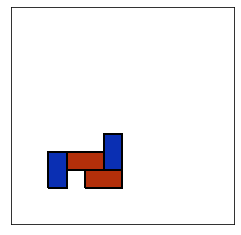

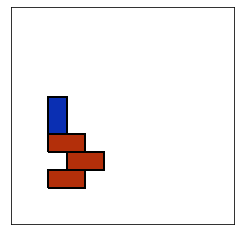

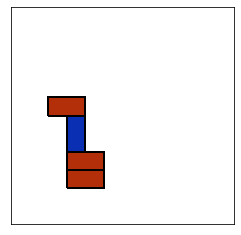

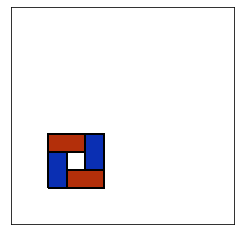

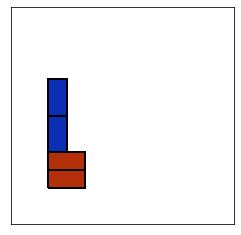

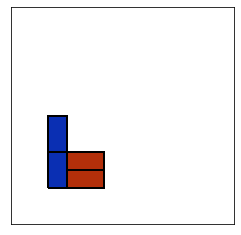

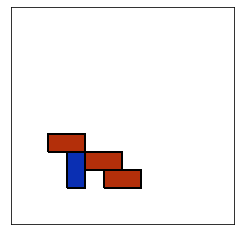

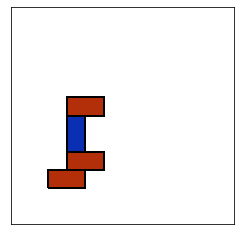

In [314]:
for blocks in towers_with_n_blocks_supported:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.populate_from_block_list(blocks)
#     print(w.fully_connected())
    utils.draw_world(w)

#### Filter towers for 2 horizontal, 2 vertical blocks

In [320]:
# Filter towers based on how many blocks are off ground level

towers_2x2 = [tower for tower in towers_with_n_blocks_supported \
                                  if utils.worldify(tower).two_h_two_v()]

print(str(len(towers_2x2)) + ' towers with 2 horizontal and 2 vertical blocks')



107 towers with 2 horizontal and 2 vertical blocks


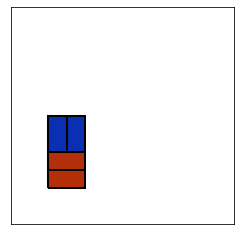

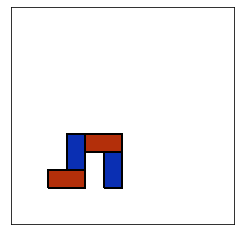

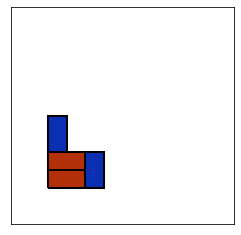

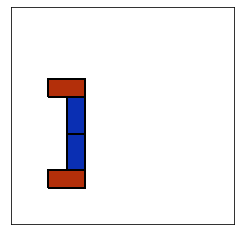

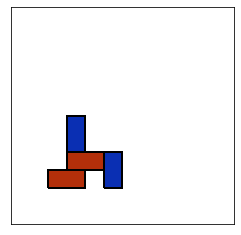

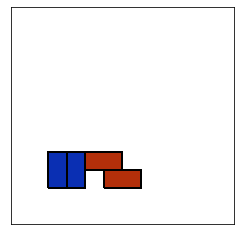

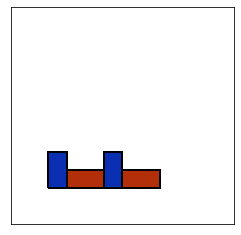

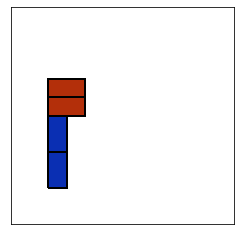

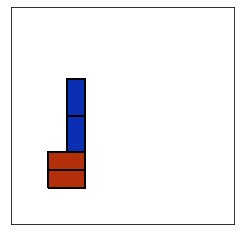

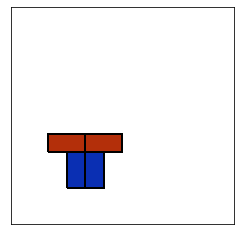

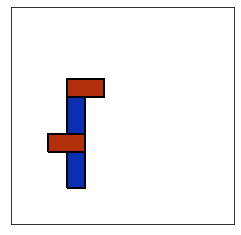

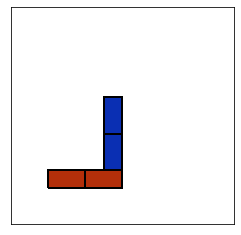

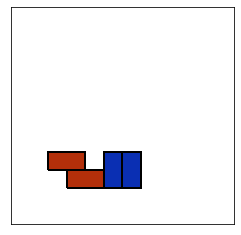

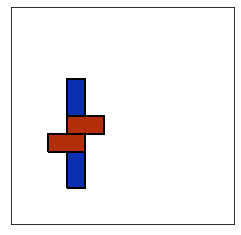

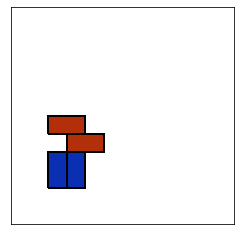

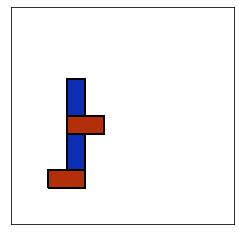

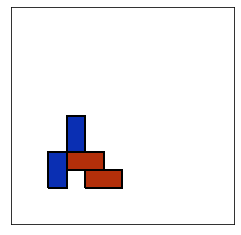

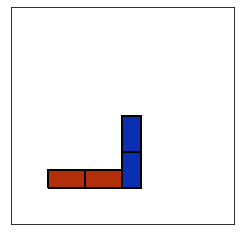

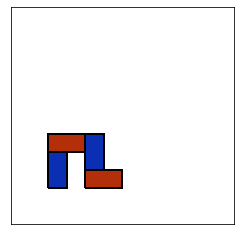

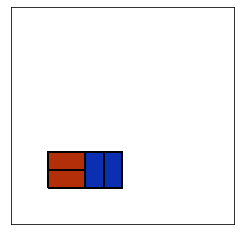

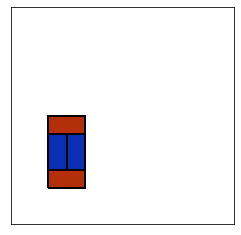

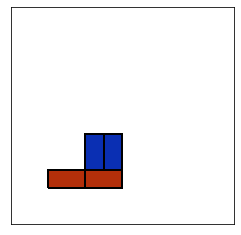

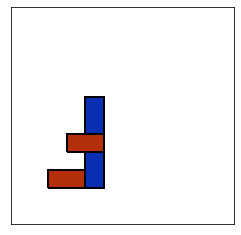

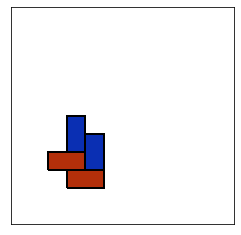

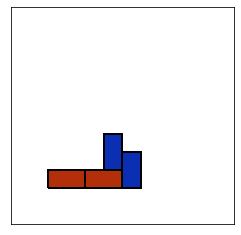

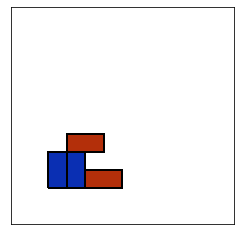

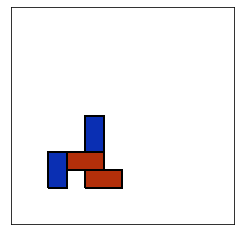

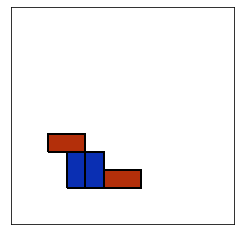

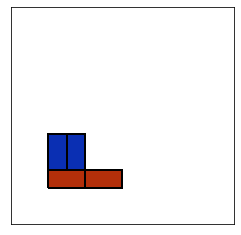

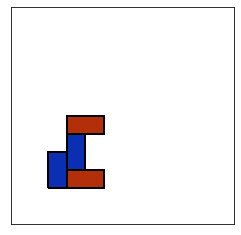

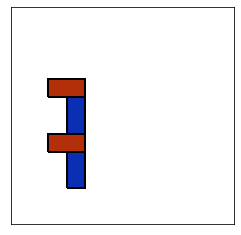

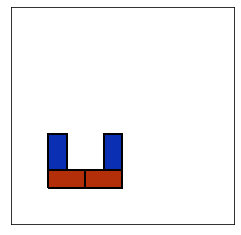

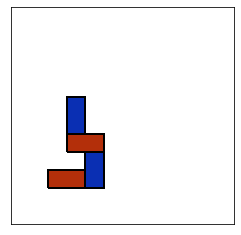

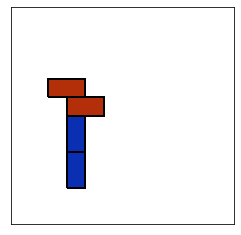

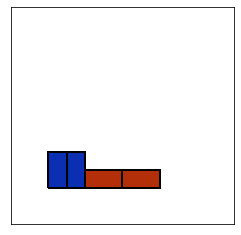

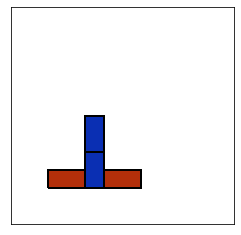

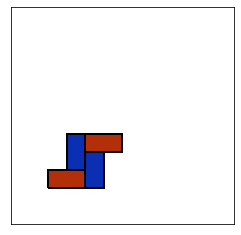

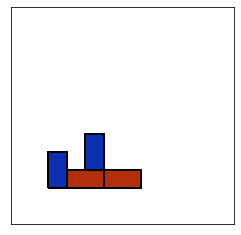

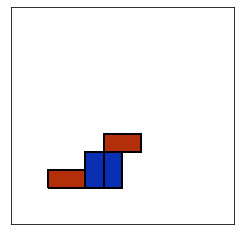

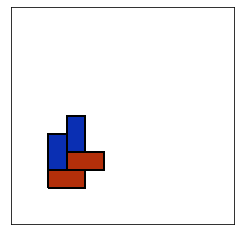

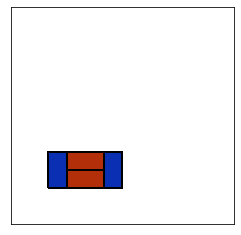

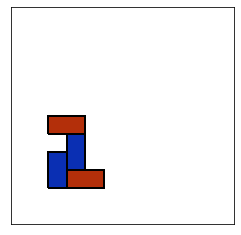

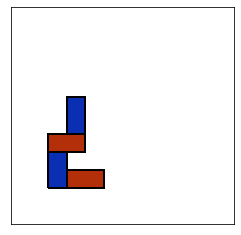

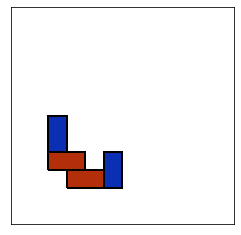

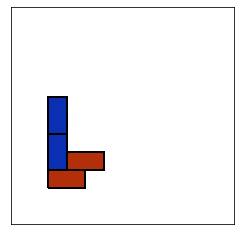

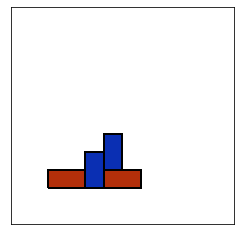

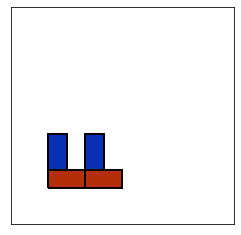

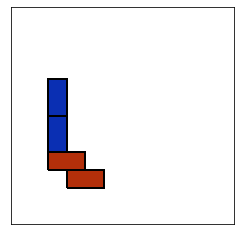

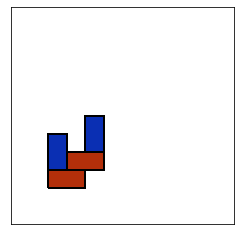

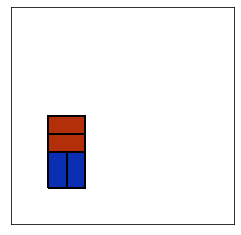

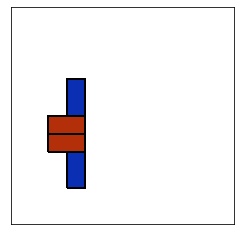

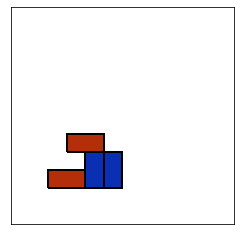

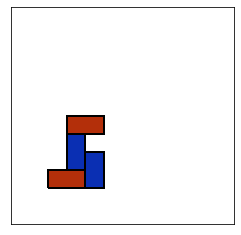

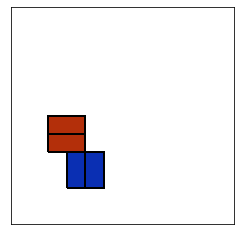

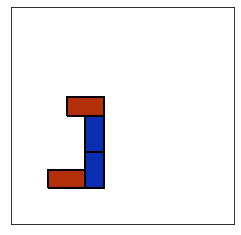

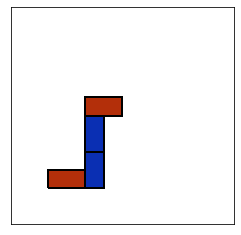

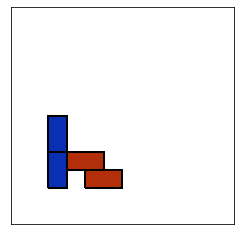

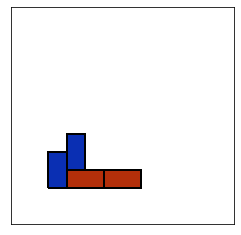

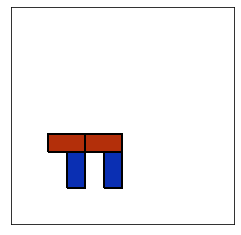

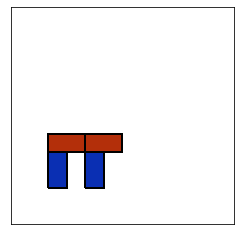

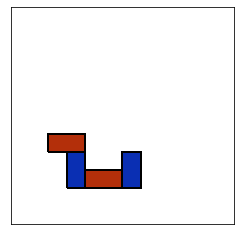

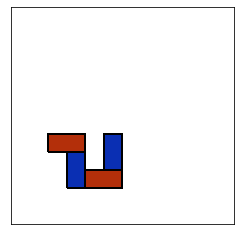

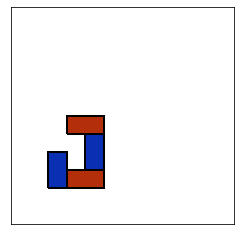

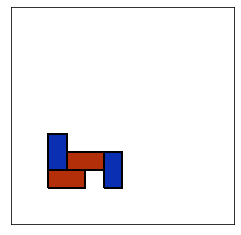

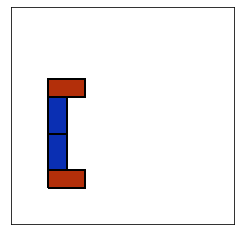

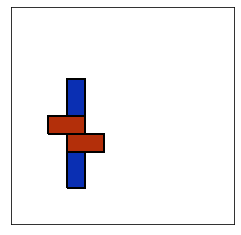

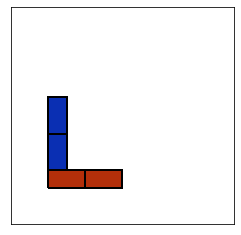

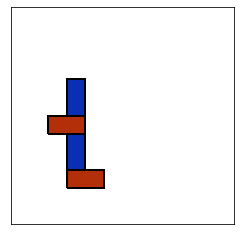

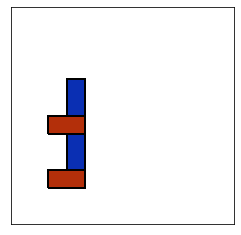

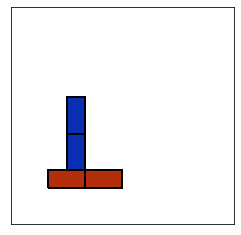

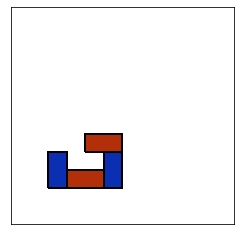

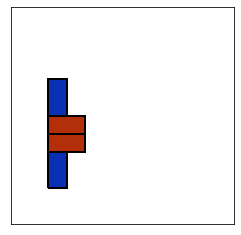

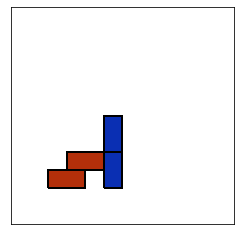

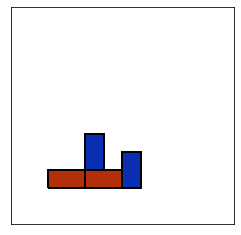

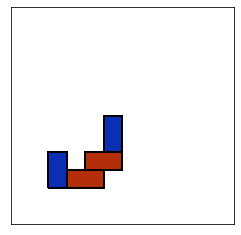

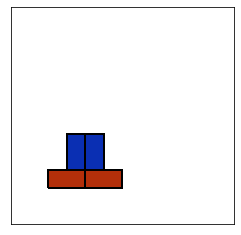

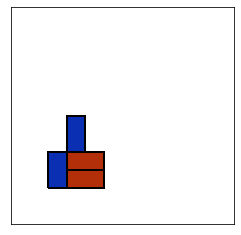

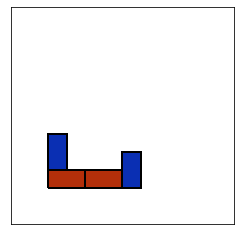

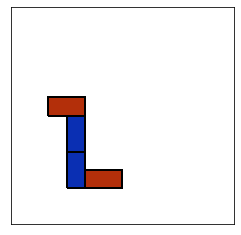

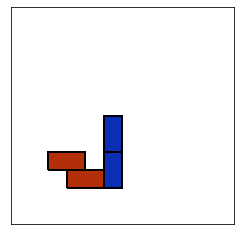

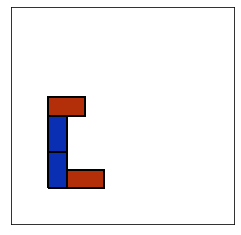

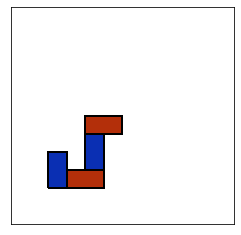

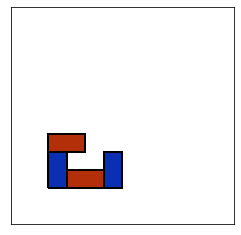

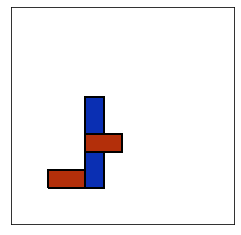

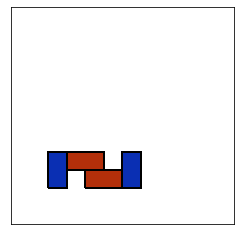

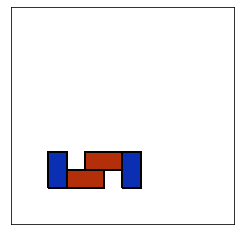

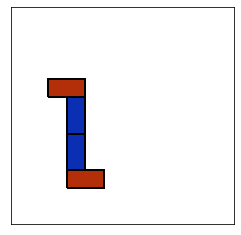

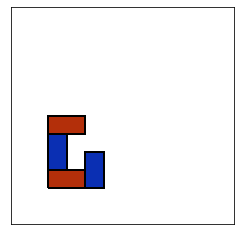

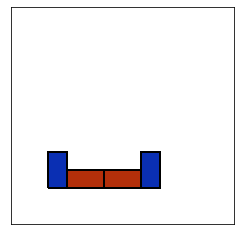

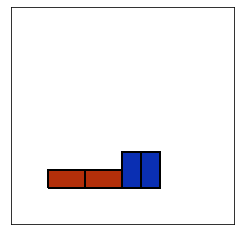

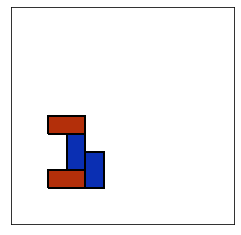

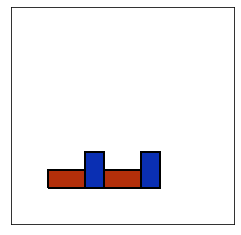

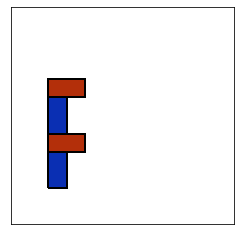

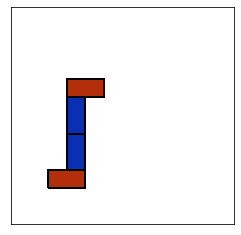

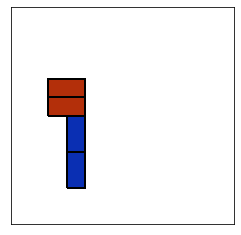

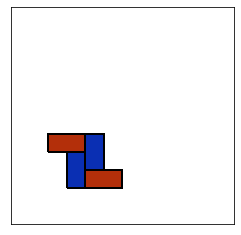

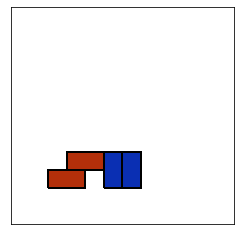

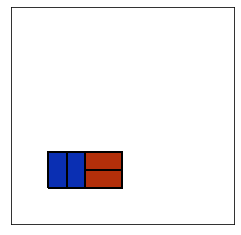

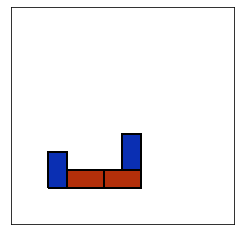

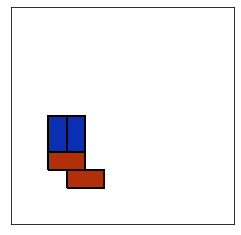

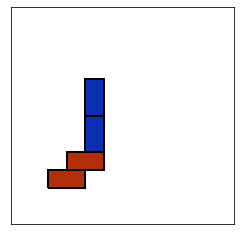

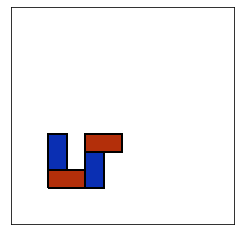

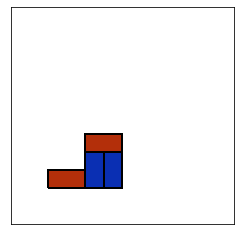

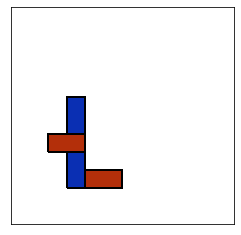

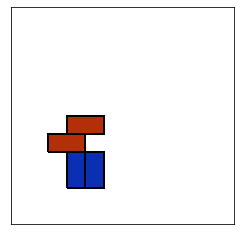

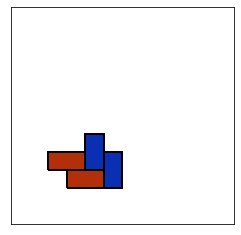

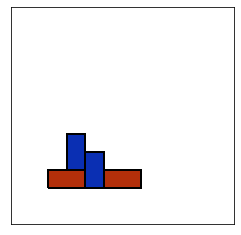

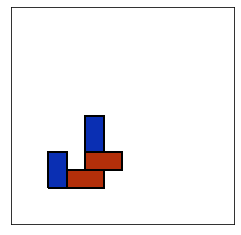

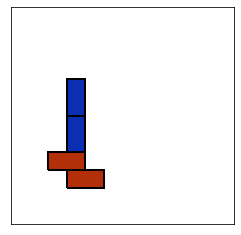

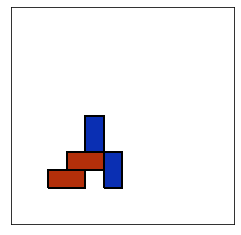

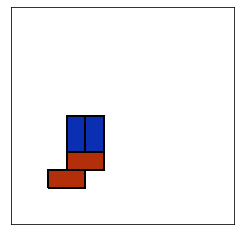

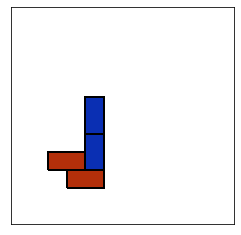

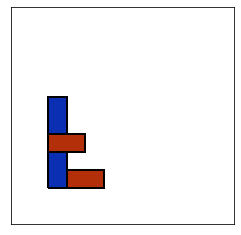

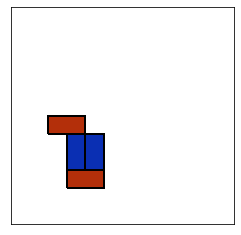

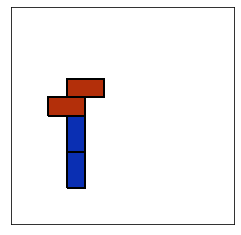

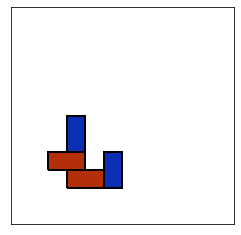

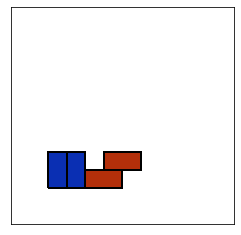

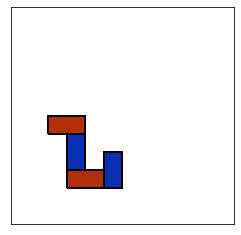

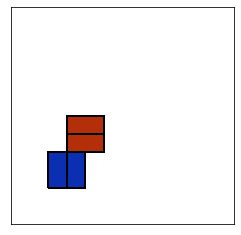

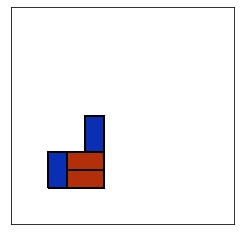

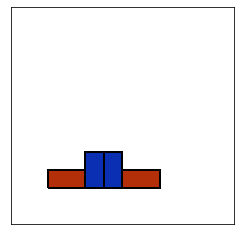

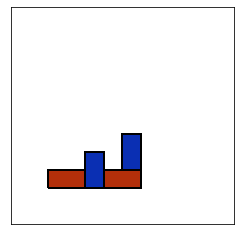

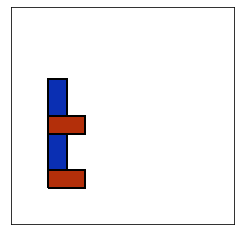

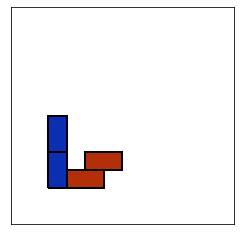

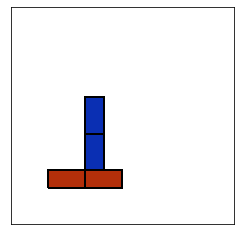

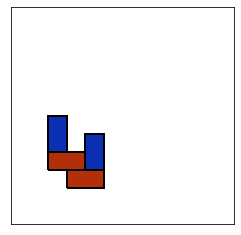

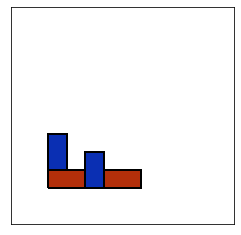

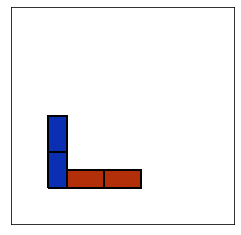

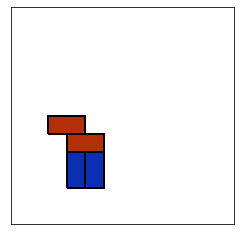

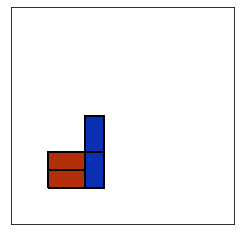

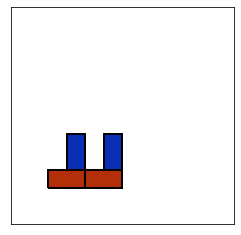

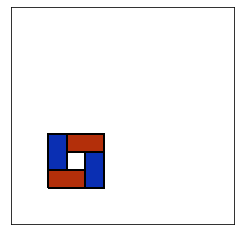

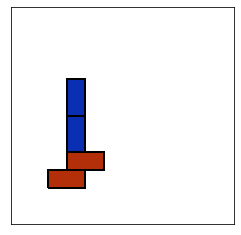

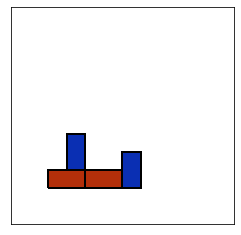

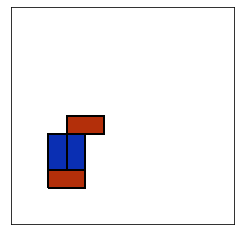

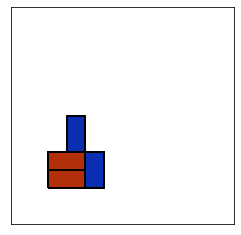

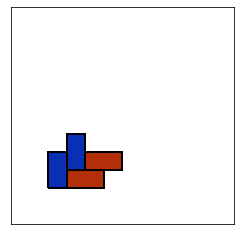

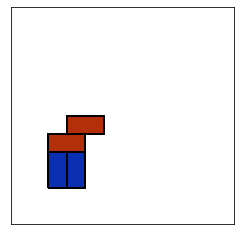

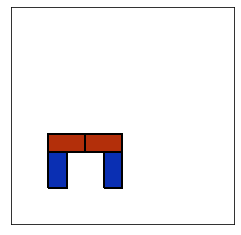

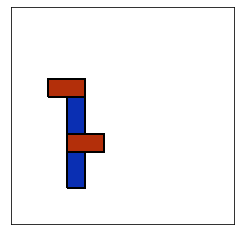

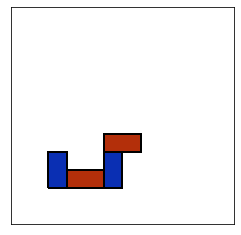

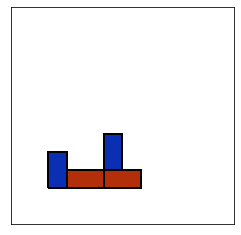

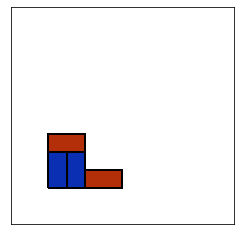

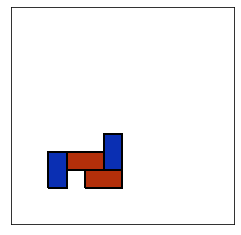

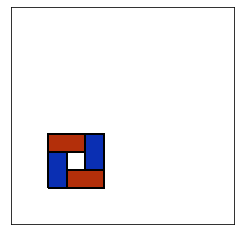

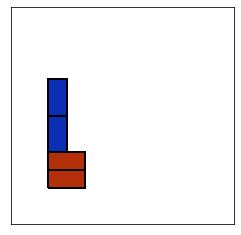

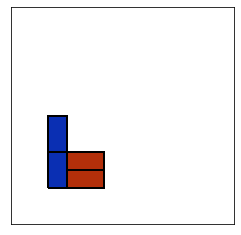

In [305]:
for blocks in towers_2x2:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.populate_from_block_list(blocks)
#     print(w.fully_connected())
    utils.draw_world(w)